Calculate K for K-nn using two different methods

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time


## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = False

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [4]:
from modules.multi_bounds import bounds_class
from modules.tight_knn_func import knn_num_calc

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
alpha = np.linspace(1, 30, 10, endpoint = True, dtype= "int")

alpha

array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30])

In [6]:
# knn_lst = np.linspace(2,6, 4 , dtype= 'int')
# # knn_lst[0] = 2
# knn_lst

method = [1,2]

In [7]:
mean_diff = .5
bound_obj_lst = []

if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:
    sample_size= 500
    MC_num = 400
    n0, n1 = sample_size, sample_size
    for i in method:
        start = time.time()
        dim_bound_list = []
        for a in alpha:
            dimensions =8


            mean1 = np.zeros(dimensions)
            covariance1 = np.identity(dimensions)

            mean2 = np.zeros(dimensions)

            mean2[0] = mean_diff

            covariance2= np.identity(dimensions)

            mean1 = np.array(mean1)
            mean2 = np.array(mean2)
            params1  = [mean1, covariance1, n0]
            params2  = [mean2, covariance2, n1]
            if i ==1:
                k= knn_num_calc(sample_size, dimensions)
            if i ==2:
                k = int(np.sqrt(sample_size))

            tight_params = [a, k ]

            bound_types = ["tight"]

            bounds = bounds_class("mv_normal", params1, params2, threads =2, bound_types =bound_types,  MC_num = MC_num, tight_params = tight_params )

            dim_bound_list.append(bounds)
        bound_obj_lst.append(dim_bound_list)

        end = time.time()
        print("done with ", i, " in ",  end -start )



done with  1  in  42.42056679725647
done with  2  in  56.677032232284546


##### Pickling
This is where the data either gets save or loaded

In [8]:
file_path = 'sim_data/knn_num_method.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst = loaded_objects

Objects saved to sim_data/knn_num_method.pkl


### Using the data

may or not be pickled. 

In [9]:


tight_l = []
tight_u = []

for i in range(len(method)):
    l1 = []
    l2 = []
    for j in range(len(alpha)):
        l, u = bound_obj_lst[i][j].get_bounds_tight()
        lower  = np.mean(l)
        upper = np.mean(u)
        
        l1.append(lower)
        l2.append(upper)
    tight_l.append(l1)
    tight_u.append(l2)
    
#         a, b = obj.get_bounds_tight()
#         tight_l.append(np.mean(a))
#         tight_u.append(np.mean(b))



In [10]:
lower, upper = [], []

In [11]:

sample_size= 500
dimension =1
            
n0, n1 = sample_size, sample_size

mean0 = np.zeros(dimension)
covariance0 = np.identity(dimension)


mean1 = np.zeros(dimension)
mean1[0] = mean_diff
covariance1= np.identity(dimension)
# mean1 = np.array(mean1)


In [12]:
from scipy.stats import multivariate_normal
from modules.tight_knn_func import __calc_tight_bounds_via_knn_density

for i in range(500):

    data0 =  np.random.multivariate_normal(mean0, covariance0, n0)
    data1 =  np.random.multivariate_normal(mean1, covariance1, n1)

    X = np.concatenate([data0, data1])

    y0 = multivariate_normal.pdf(X, mean0, cov= covariance0)
    y1 = multivariate_normal.pdf(X, mean1, cov=covariance1)

    a = 10
    a, b = __calc_tight_bounds_via_knn_density(y0, y1, alpha = a)
    lower.append(a), upper.append(b)

In [13]:
np.mean(lower), np.mean(upper)

(0.37884642332683827, 0.44328151438000984)

In [14]:
from sklearn.neighbors import NearestNeighbors

k = 3
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data0)
distances, indices = knn.kneighbors(X) # get distance to the  1,2,... kth nearest neighbor across the space x
distances




array([[0.        , 0.00247148, 0.00257167],
       [0.        , 0.00508969, 0.01235664],
       [0.        , 0.00048752, 0.02257103],
       ...,
       [0.0004261 , 0.00249962, 0.00345391],
       [0.00023862, 0.00868789, 0.01511339],
       [0.00280057, 0.00493031, 0.01234129]])

In [15]:
data0 =  np.random.multivariate_normal([0,0], [[1,0],[0,1]], 10)

print(data0)
k = 2
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data0)
distances, indices = knn.kneighbors([[0,0], [1,1]]) # get distance to the  1,2,... kth nearest neighbor across the space x
distances, indices



# len(distances)

[[ 2.22110893 -0.97735616]
 [ 0.94767705 -1.98977156]
 [ 0.60245952  0.6199553 ]
 [-0.15715422  1.03035919]
 [-0.0093594   0.71582363]
 [-1.46584887 -1.04140254]
 [-0.30787626 -0.71266729]
 [-1.14104678 -0.30489996]
 [ 0.2694416  -0.1131464 ]
 [-0.08692978  0.10969934]]


(array([[0.13996689, 0.29223429],
        [0.54997492, 1.04860031]]),
 array([[9, 8],
        [2, 4]]))

In [16]:
exact = []

for i in alpha:
    dx = 0.001
    x = np.arange(-7, 7 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - mean_diff)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

print("BER 2d:", BER)

BER 2d: 0.40129368237187935


In [17]:
np.where(method==[2])

/tmp/ipykernel_226044/1119976950.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(method==[2])


(array([], dtype=int64),)

In [18]:
method

[1, 2]

In [19]:
indices = np.nonzero(method==int(1))
indices

(array([], dtype=int64),)

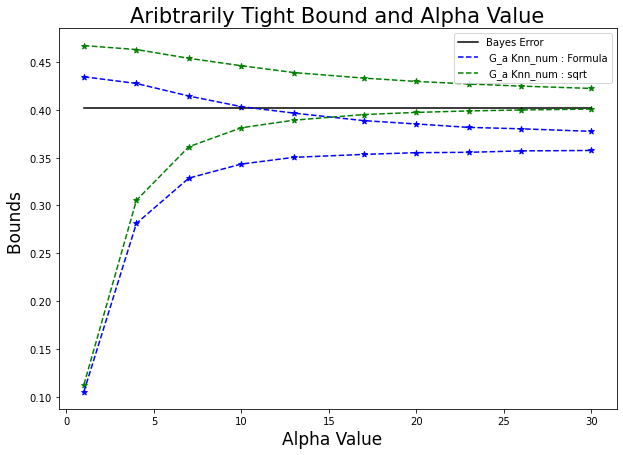

In [20]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)



ax.plot(alpha, exact, 'k', label='Bayes Error')


custom = np.array(method)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange']

for j, c in enumerate(custom):
#     print(c)
    i = np.where(method==c)[0][0] #get index

    color = colors[j]
    style= str(color + "--")
    if c ==1:
        label_str = "Formula"
    if c ==2:
        label_str = "sqrt"
    
    ax.plot(alpha, tight_l[i], style, label=' G_a Knn_num : ' +label_str )
    ax.plot(alpha, tight_u[i], style)
    ax.scatter(alpha, tight_l[i], color  = color,  marker='*')
    ax.scatter(alpha, tight_u[i], color = color, marker ='*' )

ax.set_xlabel("Alpha Value  ", fontsize = fs)
ax.set_ylabel("Bounds ", fontsize=fs)
ax.set_title("Aribtrarily Tight Bound and Alpha Value", fontsize = fs +4)
ax.legend()
# plt.savefig("alpha.png",facecolor=(1,1,1,1))

plt.show()
